## Alessandro Bianchetti

## Exercise 7

Consider a bivariate Gaussian distribution N($\mu$,$\Sigma$), where $\mu$ = (4, 2),
$\Sigma_{11}$ = 1.44, $\Sigma_{22}$ = 0.81, $\Sigma_{12}$ = $\Sigma_{12}$ = −0.702. Assume that such distribution
describes the posterior of two parameters $X_1$ and $X_2$. Plot contours
of this distribution and tell what are the boundaries of the 95\% credibile
interval for each parameter, after marginalizing over the other. Tell how
these boundaries change if, instead of marginalizing, we fix either parameter
to a known value. Now, re-obtain the same boundaries via Monte
Carlo sampling of the posterior, in three ways: a) by directly drawing values
of ($X_1$,$X_2$), by mean of a a Cholesky decomposition of the covariance
(check in the literature how to do this); b) Via Metropolis-Hastings sampling
of the posterior, c) Via Gibbs sampling of the posterior. In all cases,
do not rely on pre-made code, but write your own (i.e., you can surely
use libraries to generate known distributions, do Cholesky decomposition,
and so on, but you should not use a pre-made library with a command like
”Gibbs-sampling”). In all cases, provide final contour plots, and marginalized
posteriors. In the MCMC analysis, produce also trace plots to test
for convergence of the chains. 

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from numpy.random import random, seed
from scipy.stats import multivariate_normal as mvn
import scipy.integrate as integrate

#plt.rcParams['axes.xmargin'] = 0
#plt.rcParams['axes.ymargin'] = 0
%matplotlib inline

## Part 0: getting acquainted with plots

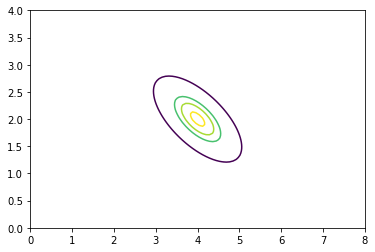

In [2]:
D = int(2)
x = np.random.rand(D)
mu = np.array([4,2],float)
cov = np.array([[1.44,-0.702],[-0.702,0.81]])
det = cov[0,0]*cov[1,1]-cov[0,1]**2
prec = np.linalg.inv(cov)


# Generate grid points
x, y = np.meshgrid(np.linspace(0,8,100),np.linspace(0,4,100))
xy = np.column_stack([x.flat, y.flat])

# density values at the grid points
z = mvn.pdf(xy, mu, cov).reshape(x.shape)

# arbitrary contour levels
max = 0.19371
contour_level = [0.68*max,0.9*max,0.95*max,0.99*max]

fig = plt.contour(x, y, z, levels = contour_level)
plt.show()

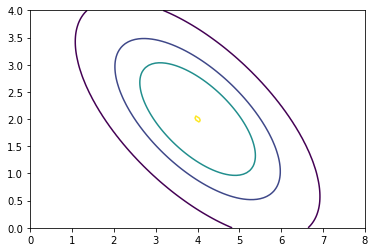

In [3]:
contour_level = [0.01,0.05,0.1,0.1935]

fig = plt.contour(x, y, z, levels = contour_level)
plt.show()

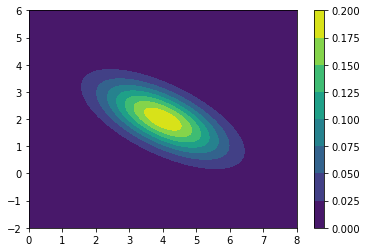

In [4]:
N = int(1000)
xvec = np.linspace(0,8,N)
yvec = np.linspace(-2,6,N)
x, y = np.meshgrid(xvec,yvec)
#xy = np.column_stack([x.flat, y.flat])
xy = np.dstack((x, y))
rv = mvn(mu, cov)
z = rv.pdf(xy)

cs = plt.contourf(x, y, z, cmap="viridis")
cbar = plt.colorbar(cs, orientation="vertical")

#print(rv.pdf(xy))

plt.tight_layout
plt.show()

A couple of useful functions:

In [5]:
def gaussian(x,any_mean,any_sigma):
    c = 1./np.sqrt(any_sigma)*1/(2*np.pi)**0.5*np.e**(-0.5*(x-any_mean)**2/any_sigma)
    return c

In [6]:
#useful functions
alpha = 0.95
eps=1e-4

def find_95(any_mean,any_sigma):
    interval_y = [any_mean-eps, any_mean+eps]
    I=[0,0]

    while(I[0]<alpha): 
        I = integrate.quad(gaussian, interval_y[0], interval_y[1], epsrel=1.e-5, args=(any_mean,any_sigma))
        interval_y[0] -= eps
        interval_y[1] += eps
        #print(interval_y)
        
    return interval_y


## Part 1: marginalization
We marginalize the original BVN over X to get the posterior for Y. The marginalization process over a MVN is known to yield another MVN with the untouched mean component of the non-marginalised variables, whilst affecting the variance. In our case, we have a univariate normal distribution with mean $\mu_y$ and variance $C_{yy}$, ie by the corresponding entry of the covariance matrix. If we label $C^{-1}=V$ as the precision matrix, we can write the marginalised posterior as
$$
UVN(y) = \mathcal{N}(y|\mu_y, (V_{yy}-V_{xy}V_{xx}^{-1}V_{xy})^{-1}) = \mathcal{N}(y|\mu_y, C_{yy})
$$
We can perform the integration in two different ways. First, we use \textit{scipy.quad} to loop over that integral until we find the correct interval. 


In [7]:
# first we marginalize over x: the mean for y is unchanged, while covariance changes. In particular, in this 2x2 case, if we fix a parameter and work on the other, 
# we must work with the covariance entry associated to the latter
mean = mu[1]
sigma = cov[1,1]

#interval_y = [-1000, 1000]
#Itot = integrate.quad(gaussian, interval_y[0], interval_y[1], epsrel=1.e-14, args=(mean,sigma))
#print(Itot)

cred_interval = find_95(mean,sigma)
print(cred_interval)


[0.2359000000001943, 3.764100000003723]


We now marginalize over Y, thus getting the posterior for X and extracting the credibility interval in X. This time the marginalized posterior is
$$
UVN(x) = \mathcal{N}(x|\mu_x,C_{xx})
$$

In [10]:
mean = mu[0]
sigma = cov[0,0]

cred_interval = find_95(mean,sigma)
print(cred_interval)

[1.6478999999958184, 6.352099999994518]


In this simple 2D case, we quickly obtained the marginalized posterior by working with a scalar variance. But as dimensions grow, finding the analytical expression for the new covariance can become costly. An alternative path for the marginalization integral could be graphical: projecting the above 2D histogram on either axis is the exact way to visualize the marginalization process. After projection, we get a univariate Gaussian, for which we can calculate the credibility interval. We do this for y, then for x.

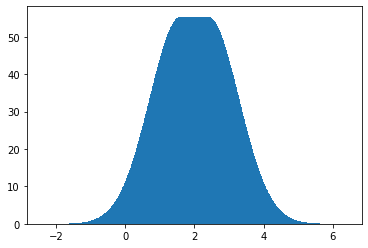

0.23423423423423406 3.7737737737737733


In [11]:
marg_post_y = np.zeros(N, float)
for i in range(N):
    for j in range(N):
        marg_post_y[i] += z[i,j]

plt.bar(yvec,marg_post_y)
plt.show()

bin_width = (yvec[-1]-yvec[0])/N
I = sum(marg_post_y)*bin_width
#print(I)   we have to permorm the total integral because it is unnormalised
alpha = 0.95*I

ind = int(N/2)

ind1 = ind-1
ind2 = ind+1
I0=0
while(I0<alpha): 
    I0=0
    for j in range(ind1,ind2):
        I0 += marg_post_y[j]*bin_width
    ind1 -=1
    ind2 +=1
    

#print(I0, alpha)
#print(ind1,ind2)
print(yvec[ind1],yvec[ind2])
    

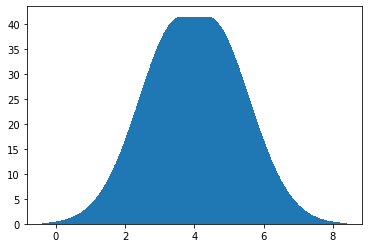

1.6496496496496496 6.358358358358358


In [12]:
marg_post_x = np.zeros(N, float)
for i in range(N):
    for j in range(N):
        marg_post_x[i] += z[j,i]

plt.bar(xvec,marg_post_x)
plt.show()

bin_width = (xvec[-1]-xvec[0])/N
I = sum(marg_post_x)*bin_width
alpha = 0.95*I 

ind = int(N/2)

ind1 = ind-1
ind2 = ind+1
I0=0
while(I0<alpha): 
    I0=0
    for j in range(ind1,ind2):
        I0 += marg_post_x[j]*bin_width
    ind1 -=1
    ind2 +=1
    
    

#print(I0, alpha)
#print(ind1,ind2)
print(xvec[ind1],xvec[ind2])
        

We're happy to notice that both methods produce the same credibility intervals on the two parameters.

In [30]:
# for some reason I don't understand I have to re-run this cell with the function before going on with conditioning, otherwise the following cells won't run

alpha = 0.95
eps=1e-4

def find_95(any_mean,any_sigma):
    interval_y = [any_mean-eps, any_mean+eps]
    I=[0,0]

    while(I[0]<alpha): 
        I = integrate.quad(gaussian, interval_y[0], interval_y[1], epsrel=1.e-5, args=(any_mean,any_sigma))
        interval_y[0] -= eps
        interval_y[1] += eps
        #print(interval_y)
        
    return interval_y

## Part 2: conditioning

Next step is computing the credibility interval after fixing either parameter, instead of marginalizing over it. We take the BVN and just fix both parameters, one at a time, to their correspondent mean value. Conditioning produces another MVN with unchanged covariance, but new mean. A conditioned BVN (fixed y) becomes the following UVN(x)
$$
UVN(x) = \mathcal{N}(x|\mu_x-V_{xx}^{-1}V_{xy}(y-\mu_y),V_{xx}^{-1})
$$

In [10]:
# check the form of the conditioning

sigma_cond_x = 1./np.sqrt(prec[0,0])
y_sample = np.random.normal(loc=mu[1], scale=cov[1,1],size=20)
y = sum(y_sample)/len(y_sample)
mean_cond_x = mu[0]-prec[0,1]/prec[0,0]*(y-mu[1])      #fixing y to its mean cancels the extra term. Watch out, fixing the parameter influences the obtained interval
print(mean_cond_x)

#interval_x = [-1000, 1000]
#Itot = integrate.quad(gaussian, interval_x[0], interval_x[1], epsrel=1.e-7,args=(mean,sigma))
#print(Itot)
#alpha = Itot[0]*0.95


cred_interval_cond_x = find_95(mean_cond_x,sigma_cond_x)
print(cred_interval_cond_x)

3.9502053561846076
[2.0784053561806575, 5.822005356180466]


In [11]:
sigma_cond_y = 1./np.sqrt(prec[1,1])
x_sample = np.random.normal(loc=mu[0], scale=cov[0,0],size=20)
x = sum(x_sample)/len(x_sample)
mean_cond_y = mu[1]-prec[0,1]/prec[1,1]*(x-mu[0])      #fixing y to its mean cancels the extra term. Watch out, fixing the parameter influences the obtained interval
print(mean_cond_y)

#interval_x = [-1000, 1000]
#Itot = integrate.quad(gaussian, interval_x[0], interval_x[1], epsrel=1.e-7,args=(mean,sigma))
#print(Itot)
#alpha = Itot[0]*0.95


cred_interval_y = find_95(mean_cond_y,sigma_cond_y)
print(cred_interval_y)

1.9664866448598726
[0.3453866448600511, 3.587586644863219]


The credibility intervals are different with respect to the marginalization case. First of all, we're treating a physical situation in which we assume to know part of the parameters (nuisance parameters) and we're fixing them to a given value. In the above code, we fixed either x or y to a random value. The obtained credibility interval depends on the fixed variable too, since every new random generation produces a new credibility interval.

## Part 3: Cholesky decomposition

Credibility intervals are now computed by applying a Cholesky decomposition of the covariance. In a nutshell, Cholesky decomposition is to decompose a positive definite matrix into the product of a lower triangular matrix and its transpose.

In [34]:
L = np.linalg.cholesky(cov) # Cholesky decompositionplt.figure(figsize = (12, 6))

r = np.random.normal(loc=0.0, scale=1.0, size=(int(1e5),2))
v = []
for item in r:
    v.append(np.dot(L,item)+mu)
#print(v)
#print(v[0][0])

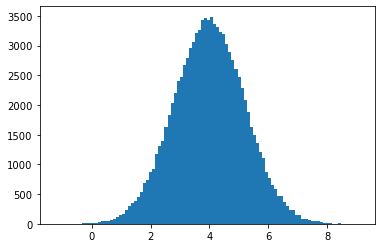

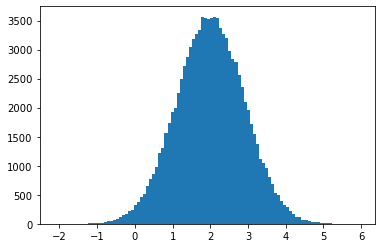

In [35]:
X = []
Y = []
for item in v:
    X.append(item[0])
    Y.append(item[1])

nbins = int(100)
nx, binsx, _ = plt.hist(X,bins=nbins)
plt.show()

ny, binsy, _ = plt.hist(Y,bins=nbins)
plt.show()

In [36]:
bin_width_x = (binsx[-1]-binsx[0])/nbins
print(bin_width_x)
I = bin_width_x * sum(nx[0:99])
print(I)
alpha = 0.95*I

bin_mean_x = int((mu[0]-binsx[0])/bin_width_x)
print(bin_mean_x)
bin1 = bin_mean_x-1
bin2 = bin_mean_x+1
I=0
while(I<alpha): 
    I=0
    I = bin_width_x * sum(nx[bin1:bin2])
    bin1 -= 1
    bin2 += 1


print(I)
print(bin1,bin2)
print(binsx[0]+bin1*bin_width_x,binsx[0]+bin2*bin_width_x)

0.10339063950604199
10338.960559964693
50
9835.65492684928
26 74
1.4401117753387185 6.402862471628734


In [37]:
bin_width_y = (binsy[-1]-binsy[0])/nbins
print(bin_width_y)
Iy = bin_width_y * sum(ny[0:99])
print(Iy)
alpha = 0.95*Iy

bin_mean_y = int((mu[1]-binsy[0])/bin_width_y)
print(bin_mean_y)
bin1 = bin_mean_y-1
bin2 = bin_mean_y+1
Iy=0
while(Iy<alpha): 
    Iy=0
    Iy = bin_width_y * sum(ny[bin1:bin2])
    bin1 -= 1
    bin2 += 1


print(Iy)
print(bin1,bin2)
print(bin1*bin_width_y,bin2*bin_width_y)

0.08067940072904153
8067.859393503424
51
7674.143917945702
28 74
2.259023220413163 5.970275653949074


## Part 4: Metropoli-Hastings

Now we try out the Metropoli-Hastings method to sample the BVN. We need to define a new distribution Q, possibly symmetric like a MVN, and draw from it. An acceptance step is then considered, to check whether or not the next sample is validated.

In [38]:
#define Q
def gauss_2d(mean, sigmax, sigmay):
    a = np.random.normal(loc=mean[0], scale=sigmax, size=1)
    b = np.random.normal(loc=mean[1], scale=sigmay, size=1)
    return list(map(list, zip(a, b)))[0]

#define acceptance rate
def acceptance(next, curr):
    prob_next = mvn.pdf(next,mu,cov)
    prob_curr = mvn.pdf(curr,mu,cov)
    alpha = min(prob_next/prob_curr,1)
    return alpha

def random_coin(p):
    k = np.random.uniform(0,1)
    if k>=p:
        return False
    else:
        return True

N=int(1e4)
r = mu
fin = []
Tr = 0.
trace = []
while(len(fin)<N):
    fin.append(r)
    rplus = gauss_2d(r,1.5,1.0)
    Tr -= np.log(mvn.pdf(rplus,mu,cov))/len(fin)
    trace.append(Tr)
    alpha = acceptance(rplus,r)
    bool = random_coin(alpha)
    if(bool):
        r = rplus

        

fin = np.array(fin)
#burnin = int(0.2*len(fin))
#fin = fin[burnin:]

print(len(fin))
#print(fin)

10000


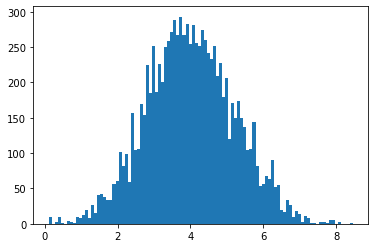

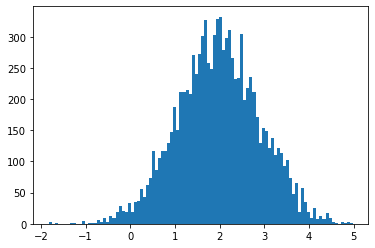

In [39]:
xtry = []
for i in range(int(len(fin))):
    xtry.append(fin[i][0])
ytry = []
for i in range(int(len(fin))):
    ytry.append(fin[i][1])

plt.hist(xtry,bins=100)
plt.show()


plt.hist(ytry,bins=100)
plt.show()

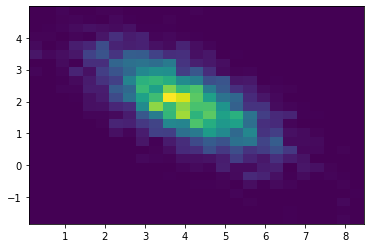

In [40]:
plt.hist2d(xtry,ytry,bins=(25,25))

plt.tight_layout
plt.show()

In [41]:
#another chain
r = (3.,3.)
fin2 = []
Tr = 0.
trace2 = []
while(len(fin2)<N):
    fin2.append(r)
    Tr -= np.log(mvn.pdf(rplus,mu,cov))/len(fin2)
    trace2.append(Tr)
    rplus = gauss_2d(r,1.5,1.0)
    alpha = acceptance(rplus,r)
    bool = random_coin(alpha)
    if(bool):
        r = rplus

        

fin2 = np.array(fin2)
print(len(fin2))

#another chain
r = (0.,0.)
fin3 = []
Tr = 0.
trace3 = []
while(len(fin3)<N):
    fin3.append(r)
    Tr -= np.log(mvn.pdf(rplus,mu,cov))/len(fin3)
    trace3.append(Tr)
    rplus = gauss_2d(r,1.5,1.0)
    alpha = acceptance(rplus,r)
    bool = random_coin(alpha)
    if(bool):
        r = rplus

        

fin3 = np.array(fin3)
print(len(fin3))

#another chain
r = (5.,1.)
fin4 = []
Tr = 0.
trace4 = []
while(len(fin4)<N):
    fin4.append(r)
    Tr -= np.log(mvn.pdf(rplus,mu,cov))/len(fin4)
    trace4.append(Tr)
    rplus = gauss_2d(r,1.5,1.0)
    alpha = acceptance(rplus,r)
    bool = random_coin(alpha)
    if(bool):
        r = rplus

        

fin4 = np.array(fin4)
print(len(fin4))

10000
10000
10000


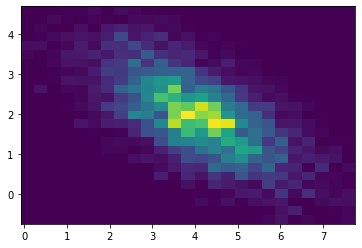

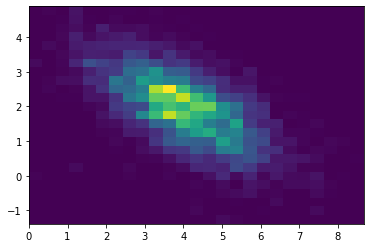

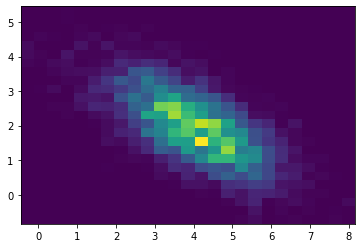

In [42]:
xtry2 = []
for i in range(int(len(fin2))):
    xtry2.append(fin2[i][0])
ytry2 = []
for i in range(int(len(fin2))):
    ytry2.append(fin2[i][1])

plt.hist2d(xtry2,ytry2,bins=(25,25))

plt.tight_layout
plt.show()

xtry3 = []
for i in range(int(len(fin3))):
    xtry3.append(fin3[i][0])
ytry3 = []
for i in range(int(len(fin3))):
    ytry3.append(fin3[i][1])

plt.hist2d(xtry3,ytry3,bins=(25,25))

plt.tight_layout
plt.show()

xtry4 = []
for i in range(int(len(fin4))):
    xtry4.append(fin4[i][0])
ytry4 = []
for i in range(int(len(fin4))):
    ytry4.append(fin4[i][1])

plt.hist2d(xtry4,ytry4,bins=(25,25))


plt.tight_layout
plt.show()

Convergence test and Gelman-Rubin test for the variance follow

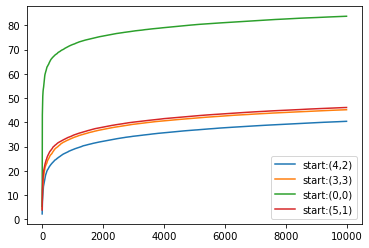

In [43]:
mvec = np.linspace(1,len(fin),len(fin))
plt.plot(mvec, trace, label="start:(4,2)")
plt.plot(mvec, trace2, label="start:(3,3)")
plt.plot(mvec, trace3, label="start:(0,0)")
plt.plot(mvec, trace4, label="start:(5,1)")
plt.legend()
plt.show()

Let's perform the Gelman-Rubin test for the variance

In [44]:
av = sum(fin)/int(len(fin))
av2 = sum(fin2)/int(len(fin2))
av3 = sum(fin3)/int(len(fin3))
av4 = sum(fin4)/int(len(fin4))
av_tot = sum

av_theta = np.array([av,av2,av3,av4])   # array of the averages, each component is the mean of a chain
#print(av_theta)

av_tot = sum(av_theta)/4
print(av_tot)

[4.02584102 1.96362928]


In [48]:
def chain_var(vec,mean):
    s = 0.
    for i in range(int(len(vec))):
        s += np.outer(vec[i]-av,vec[i]-av)
    s /= (len(fin)-1)
    return s

var = np.array([chain_var(fin,av),chain_var(fin2,av2),chain_var(fin3,av3),chain_var(fin4,av4)])
av_var = sum(var)/4
#print(av_var)

z = 0.
for j in range(4):
    z += np.outer(av_theta[j]-av_tot,av_theta[j]-av_tot)

z /= 3.
#print(z)

final_var = (len(fin)-1)/len(fin)*av_var + z
print("Estimated variance:  ", final_var)

#Gelman Rubin test
R = final_var/av_var 
R_ratio = sum(sum(R))/4
print("R=",R_ratio)


Estimated variance:   [[ 1.41108504 -0.69691934]
 [-0.69691934  0.81081026]]
R= 1.0000569905690302


## Part 5: Gibbs sampling

We now try to sample the Gaussian distribution by using GIbbs sampling. It's basically a MH, but the movement probabilities now change. We choose a component of the starting point (x,y) and fix it, then evolve the other component by sampling from the conditioned probability, given that the other is fixed. 

In [49]:
# a quick check on gaussian function

prec = np.array([[cov[1,1]/det, -cov[0,1]/det],[-cov[0,1]/det, cov[0,0]/det]])
prec = np.linalg.inv(cov)

def MVN(r):
    c = 1./(2*np.pi)*1./np.sqrt(det)*np.e**(-0.5*np.dot((r-mu), np.dot(prec, (r-mu))))
    return c

print(MVN([4,2]))
print(mvn.pdf([4,2], mu, cov))

0.19391900846025578
0.19391900846025575


In [50]:
r = [4.,2.]
N=int(1e4)
fin = []
Tr = 0.
trace = []
prec = np.linalg.inv(cov)
while(len(fin)<N):
    fin.append(r)
    k = int(np.random.uniform(0.,1.)+0.5)
    l = int(abs(k-1))
    sigma = 1./np.sqrt(prec[k,k])
    mean = mu[k]-prec[k,l]/prec[k,k]*(r[l]-mu[l])
    q = np.random.normal(mean,sigma)
    rplus = np.zeros(2,float)
    rplus[k] = q
    rplus[l] = r[l]
    r = rplus
    Tr -= np.log(mvn.pdf(r,mu,cov))/len(fin)
    trace.append(Tr)

        

fin = np.array(fin)
#burnin = int(0.2*len(fin))
#fin = fin[burnin:]
#print(fin)

print(len(fin))


10000


In [51]:
r = [3.,3.]
fin2 = []
Tr = 0.
trace2 = []
prec = np.linalg.inv(cov)
while(len(fin2)<N):
    fin2.append(r)
    k = int(np.random.uniform(0.,1.)+0.5)
    l = int(abs(k-1))
    sigma = 1./np.sqrt(prec[k,k])
    mean = mu[k]-prec[k,l]/prec[k,k]*(r[l]-mu[l])
    q = np.random.normal(mean,sigma)
    rplus = np.zeros(2,float)
    rplus[k] = q
    rplus[l] = r[l]
    r = rplus
    Tr -= np.log(mvn.pdf(r,mu,cov))/len(fin2)
    trace2.append(Tr)

        

fin2 = np.array(fin2)

r = [0.,0.]
fin3 = []
Tr = 0.
trace3 = []
prec = np.linalg.inv(cov)
while(len(fin3)<N):
    fin3.append(r)
    k = int(np.random.uniform(0.,1.)+0.5)
    l = int(abs(k-1))
    sigma = 1./np.sqrt(prec[k,k])
    mean = mu[k]-prec[k,l]/prec[k,k]*(r[l]-mu[l])
    q = np.random.normal(mean,sigma)
    rplus = np.zeros(2,float)
    rplus[k] = q
    rplus[l] = r[l]
    r = rplus
    Tr -= np.log(mvn.pdf(r,mu,cov))/len(fin3)
    trace3.append(Tr)

        

fin3 = np.array(fin3)


r = [1.,5.]
fin4 = []
Tr = 0.
trace4 = []
prec = np.linalg.inv(cov)
while(len(fin4)<N):
    fin4.append(r)
    k = int(np.random.uniform(0.,1.)+0.5)
    l = int(abs(k-1))
    sigma = 1./np.sqrt(prec[k,k])
    mean = mu[k]-prec[k,l]/prec[k,k]*(r[l]-mu[l])
    q = np.random.normal(mean,sigma)
    rplus = np.zeros(2,float)
    rplus[k] = q
    rplus[l] = r[l]
    r = rplus
    Tr -= np.log(mvn.pdf(r,mu,cov))/len(fin4)
    trace4.append(Tr)

        

fin4 = np.array(fin4)


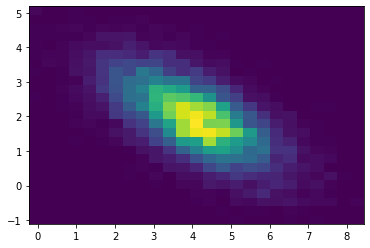

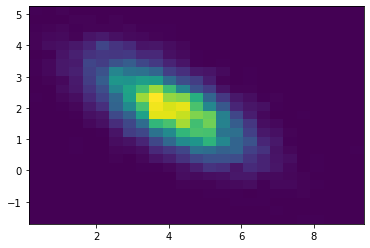

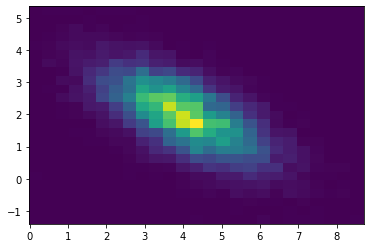

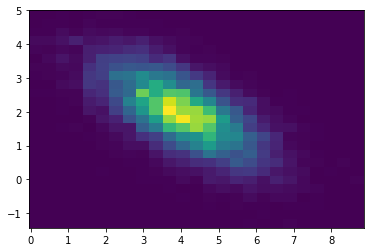

In [52]:
xtry = []
for i in range(int(len(fin))):
    xtry.append(fin[i][0])
ytry = []
for i in range(int(len(fin))):
    ytry.append(fin[i][1])

plt.hist2d(xtry,ytry,bins=(25,25))


plt.tight_layout
plt.show()

xtry2 = []
for i in range(int(len(fin2))):
    xtry2.append(fin2[i][0])
ytry2 = []
for i in range(int(len(fin2))):
    ytry2.append(fin2[i][1])

plt.hist2d(xtry2,ytry2,bins=(25,25))


plt.tight_layout
plt.show()

xtry3 = []
for i in range(int(len(fin3))):
    xtry3.append(fin3[i][0])
ytry3 = []
for i in range(int(len(fin3))):
    ytry3.append(fin3[i][1])

plt.hist2d(xtry3,ytry3,bins=(25,25))


plt.tight_layout
plt.show()

xtry4 = []
for i in range(int(len(fin4))):
    xtry4.append(fin4[i][0])
ytry4 = []
for i in range(int(len(fin4))):
    ytry4.append(fin4[i][1])

plt.hist2d(xtry4,ytry4,bins=(25,25))


plt.tight_layout
plt.show()

As in the previous case, we run convergence test and GR test.

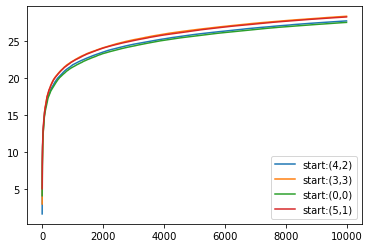

In [53]:
mvec = np.linspace(1,len(fin),len(fin))
plt.plot(mvec, trace, label="start:(4,2)")
plt.plot(mvec, trace2, label="start:(3,3)")
plt.plot(mvec, trace3, label="start:(0,0)")
plt.plot(mvec, trace4, label="start:(5,1)")
plt.legend()
plt.show()

In [55]:
av = sum(fin)/int(len(fin))
av2 = sum(fin2)/int(len(fin2))
av3 = sum(fin3)/int(len(fin3))
av4 = sum(fin4)/int(len(fin4))
av_tot = sum

av_theta = np.array([av,av2,av3,av4])   # array of the averages, each component is the mean of a chain
#print(av_theta)

av_tot = sum(av_theta)/4
print(av_tot)

def chain_var(vec,mean):
    s = 0.
    for i in range(int(len(vec))):
        s += np.outer(vec[i]-av,vec[i]-av)
    s /= (len(fin)-1)
    return s

var = np.array([chain_var(fin,av),chain_var(fin2,av2),chain_var(fin3,av3),chain_var(fin4,av4)])
av_var = sum(var)/4
#print(av_var)

z = 0.
for j in range(4):
    z += np.outer(av_theta[j]-av_tot,av_theta[j]-av_tot)

z /= 3.
#print(z)

final_var = (len(fin)-1)/len(fin)*av_var + z
print("Estimated variance:  ", final_var)

#Gelman Rubin test
R = final_var/av_var 
R_ratio = sum(sum(R))/4
print("R=",R_ratio)

[4.0366846  1.97874913]
Estimated variance:   [[ 1.44228734 -0.70882652]
 [-0.70882652  0.81842505]]
R= 1.0002002965972836
